In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, auc, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline

## Wprowadzenie i opis wybranego problemu, opis zbioru danych.

W projekcie wykorzystano zbiór danych Adult dostępny w repozytorium UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/2/adult).
Dane pochodzą ze spisu ludności Stanów Zjednoczonych 1994 roku i służą do analizy czynników wpływających na poziom dochodów osób dorosłych.

Celem projektu jest predykcja, czy roczny dochód osoby przekracza 50 tys. USD na podstawie cech demograficznych i zawodowych. Jest to problem klasyfikacji binarnej.

Oryginalny zbiór danych ma 48 842 wiersze oraz 15 zmiennych:

- **age** – wiek
- **workclass** – typ zatrudnienia
- **fnlwgt** – waga statystyczna przypisana do obserwacji
- **education** – poziom wykształcenia
- **education-num** – liczbowy odpowiednik poziomu wykształcenia
- **marital-status** – stan cywilny
- **occupation** – wykonywany zawód
- **relationship** – relacja w gospodarstwie domowym
- **race** – rasa
- **sex** – płeć
- **capital-gain** – dochód z inwestycji kapitałowych
- **capital-loss** – strata kapitałowa
- **hours-per-week** – liczba godzin pracy tygodniowo
- **native-country** – kraj pochodzenia
- **income** – zmienna docelowa określająca, czy dochód przekracza 50 tys. USD (`>50K`) czy nie (`<=50K`)

## Dataset preprocessing

In [4]:
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
#print(adult.metadata) 
# variable information 
#print(adult.variables) 

In [6]:
print(X.shape, y.shape)

(48842, 14) (48842, 1)


In [7]:
# skleimy dane w jeden dataset
dataset = pd.concat([X, y], axis=1)
dataset.shape

(48842, 15)

In [8]:
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# Podstawowe statystyki dla zmiennych kategorialnych
dataset.describe(include=["O"])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,47879,48842,48842,47876,48842,48842,48842,48568,48842
unique,9,16,7,15,6,5,2,42,4
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,24720


In [10]:
# Podstawowe statystyki dla zmiennych ciągłych
dataset.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


**Braki danych**

In [20]:
# Wyświetlenie informacji o zmiennych jakościowych - unikalne wartości
for col in dataset.select_dtypes(['object']): 
    print(dataset[col].unique())

['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
['Male' 'Female']
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Tha

In [22]:
# część braków danych jest oznaczona jako '?', zamieniamy je na wartości NaN
dataset.replace('?', np.nan, inplace=True)

In [24]:
# sprawdzamy wartości nullowe
dataset.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
income               0
dtype: int64

In [26]:
# procentowy udział braków danych
missing_percent = (dataset.isnull().mean() * 100).round(2)
missing_percent[missing_percent > 0]

workclass         5.73
occupation        5.75
native-country    1.75
dtype: float64

In [28]:
# Procent braków danych jest niski - do 6% dla poszczególnych kolumn. Postanowiono usunąć brakujące wartości.
# W wyniku z całego zbioru usunięto 7.4% obesrwacji (3620 rekordów). 
dataset.dropna(inplace=True)
dataset.shape

(45222, 15)

In [30]:
# Usuwamy duplikaty
print(dataset.shape)
dataset.drop_duplicates(inplace=True)
print(dataset.shape)

(45222, 15)
(45194, 15)


**Feature engineering**

In [33]:
# Wyświetlenie informacji o zmiennych jakościowych
for col in dataset.select_dtypes(['object']): 
    print(dataset[col].value_counts())
    # armed forces w protective serv, priv-house w other

workclass
Private             33281
Self-emp-not-inc     3795
Local-gov            3100
State-gov            1946
Self-emp-inc         1645
Federal-gov          1406
Without-pay            21
Name: count, dtype: int64
education
HS-grad         14777
Some-college     9890
Bachelors        7565
Masters          2513
Assoc-voc        1958
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           822
Prof-school       785
9th               676
12th              576
Doctorate         544
5th-6th           448
1st-4th           220
Preschool          71
Name: count, dtype: int64
marital-status
Married-civ-spouse       21048
Never-married            14580
Divorced                  6294
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: count, dtype: int64
occupation
Craft-repair         6015
Prof-specialty       6003
Exec-managerial      5982
Adm-clerical         5537
Sales                

In [35]:
# Przekształcamy zmienną income na zmienną binarną
print(dataset['income'].value_counts().sort_index())
dataset['income']= dataset['income'].map(lambda x: 0 if x in ['<=50K','<=50K.'] else 1)
dataset['income'].value_counts() 

#zmienna niezbilansowana: 75% stanowią 0, 25% - 1. W dalszym modelowaniu uwzględniamy to niezbalansowanie (np. poprzez class_weight="balanced").

income
<=50K     22633
<=50K.    11355
>50K       7506
>50K.      3700
Name: count, dtype: int64


income
0    33988
1    11206
Name: count, dtype: int64

In [37]:
#łączymy wybrane kategorie w zmiennych marital-status, occupation

dataset['marital-status'] = dataset['marital-status'].replace({
    'Married-civ-spouse': 'Married',
    'Married-AF-spouse': 'Married',
    'Married-spouse-absent': 'Married'
})

dataset['occupation'] = dataset['occupation'].replace({
    'Armed-Forces': 'Protective-serv',
    'Priv-house-serv': 'Other-service'
})

In [39]:
for col in ['marital-status', 'occupation']: 
    print(dataset[col].value_counts())

marital-status
Married          21632
Never-married    14580
Divorced          6294
Separated         1411
Widowed           1277
Name: count, dtype: int64
occupation
Craft-repair         6015
Prof-specialty       6003
Exec-managerial      5982
Adm-clerical         5537
Sales                5408
Other-service        5035
Machine-op-inspct    2967
Transport-moving     2316
Handlers-cleaners    2045
Farming-fishing      1477
Tech-support         1419
Protective-serv       990
Name: count, dtype: int64


In [41]:
# Zmienne education i education-num
for col in ['education', 'education-num']: 
    print(dataset[col].value_counts())

education
HS-grad         14777
Some-college     9890
Bachelors        7565
Masters          2513
Assoc-voc        1958
11th             1619
Assoc-acdm       1507
10th             1223
7th-8th           822
Prof-school       785
9th               676
12th              576
Doctorate         544
5th-6th           448
1st-4th           220
Preschool          71
Name: count, dtype: int64
education-num
9     14777
10     9890
13     7565
14     2513
11     1958
7      1619
12     1507
6      1223
4       822
15      785
5       676
8       576
16      544
3       448
2       220
1        71
Name: count, dtype: int64


In [43]:
# tworzymy kolumnę na podstawie native-country-us
dataset['native-country-us'] = (dataset['native-country'] == 'United-States').astype(int)

In [45]:
# Usuwamy kolumnę fnlwgt, która jest wagą statystyczną przypisaną do obserwacji, nie wnosi bezpośredniej informacji predykcyjnej, 
# usuwamy kolumnę education, ponieważ mamy education_num
# Usuwamy kolumnę native-country, 
dataset.drop(["fnlwgt", 'education','native-country'], axis=1, inplace=True)

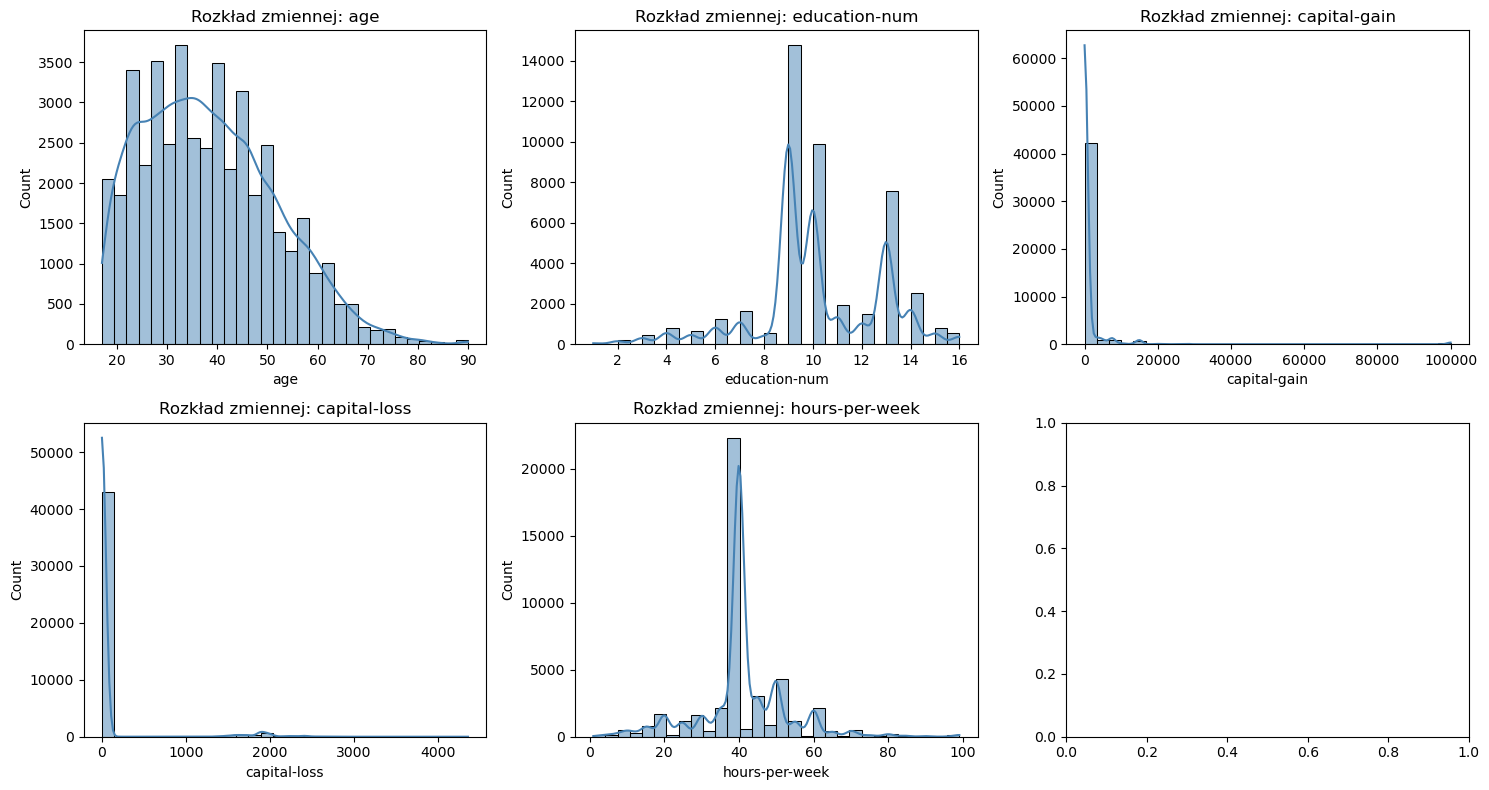

In [47]:
# Rozkłady zmiennych numerycznych
num_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(
        data=dataset,
        x=col,
        bins=30,
        kde=True,
        ax=axes[i],
        color='steelblue'
    )
    axes[i].set_title(f'Rozkład zmiennej: {col}')

plt.tight_layout()
plt.show()

Zmienne capital-gain i capital-loss charakteryzują się silnie skośnym rozkładem z dużą liczbą zer, co jest typowe dla danych finansowych.
Zamiast ich usuwania zastosowano transformację logarytmiczną, która ogranicza wpływ wartości odstających i pozwala zachować istotną informację predykcyjną.

In [49]:
#logarytmizujemy dwie zmienne
dataset['capital_gain'] = np.log1p(dataset['capital-gain'])
dataset['capital_loss'] = np.log1p(dataset['capital-loss'])
dataset.drop(['capital-gain', 'capital-loss'], axis=1, inplace=True)

<Axes: >

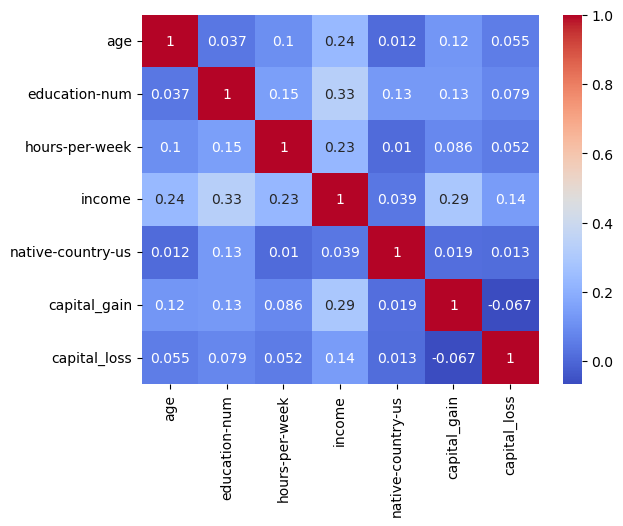

In [50]:
corr = dataset.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

# brak istotnej współliniowości pomiędzy zmiennymi numerycznymi

**EDA on cleaned data**

In [56]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45194 entries, 0 to 48841
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45194 non-null  int64  
 1   workclass          45194 non-null  object 
 2   education-num      45194 non-null  int64  
 3   marital-status     45194 non-null  object 
 4   occupation         45194 non-null  object 
 5   relationship       45194 non-null  object 
 6   race               45194 non-null  object 
 7   sex                45194 non-null  object 
 8   hours-per-week     45194 non-null  int64  
 9   income             45194 non-null  int64  
 10  native-country-us  45194 non-null  int32  
 11  capital_gain       45194 non-null  float64
 12  capital_loss       45194 non-null  float64
dtypes: float64(2), int32(1), int64(4), object(6)
memory usage: 4.7+ MB


In [58]:
# podział danych na zbiór treningowy i testowy
X = dataset.drop('income', axis=1)
y = dataset['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Przekształcanie zmiennych ciągłych
num_transformer = StandardScaler()

# Przekształcanie zmiennych jakościowych
cat_transformer = OneHotEncoder()

In [62]:
transform = ColumnTransformer(
    transformers=[
        ('num', num_transformer, ["age", "education-num", "capital_gain", "capital_loss", "hours-per-week"]),
        ('cat', cat_transformer, ["workclass", "marital-status", 'occupation', 'race',
                                  'sex',"relationship"]),
        ('bin', "passthrough", ['native-country-us'])],
        remainder = "drop"
    )  

### Model regresji logistycznej, tuning hipermarametrów

In [65]:
pipe1 = Pipeline(steps=[
    ("preprocess", transform),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# Definicja siatki hiperparametrów dla regresji logistycznej
param_grid1 = {
    "model__C": np.linspace(0.01, 10, 50),
    "model__penalty": ["l2"],
    "model__solver": ["liblinear"]
}

# GridSearchCV z 5-krotną walidacją krzyżową. Jako metrykę optymalizacji wybrano F1-score, który jest odpowiedni w przypadku niezbalansowanych klas
tuning_res_lr= GridSearchCV(
    pipe1,
    param_grid1,
    scoring="f1",
    cv=5,
    n_jobs=1,
    verbose=2
)

tuning_res_lr.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.21387755102040817, model__penalty=l2, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.21387755102040817, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.21387755102040817, model__penalty=l2, model__solver=liblinear; total time=   0.1s
[CV] END model__C=0.21387755102040817, model__penalty=l2, model__solver=liblinear; total time=   0.0s
[CV] END model__C=0.21387755102040817, model__penalty=l2, model__solver=liblinear; total time= 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education-num',
                                                                          'capital_gain',
                                                                          'capital_loss',
                                                                          'hours-per-week']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['workclass',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'race',
                                                                          'sex',
                                                                          'relationship']),
                                                                        ('bin',
                                                                         'passthrough',
                                                                         ['native-country-us'])])),
                                       ('model',
                                        LogisticRegr...
        4.08755102,  4.29142857,  4.49530612,  4.69918367,  4.90306122,
        5.10693878,  5.31081633,  5.51469388,  5.71857143,  5.92244898,
        6.12632653,  6.33020408,  6.53408163,  6.73795918,  6.94183673,
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ]),
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear']},
             scoring='f1', verbose=2)

In [67]:
# zestaw hiperparametrów, który maksymalizował średni wynik F1-score w 5-krotnej walidacji krzyżowej.
tuning_res_lr.best_params_

{'model__C': 1.233265306122449,
 'model__penalty': 'l2',
 'model__solver': 'liblinear'}

In [69]:
tuning_res_lr.best_score_

0.6748553529433788

In [71]:
#wybór najlepszego modelu
best_model_lr = tuning_res_lr.best_estimator_

#predykcje dla zbioru train/test
y_pred_test = best_model_lr.predict(X_test)
y_pred_train = best_model_lr.predict(X_train)

#obliczenie metryk jakości
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)
acc = accuracy_score(y_test, y_pred_test)
acc_train = accuracy_score(y_train, y_pred_train)

print("F1-score (test):", f1_test)
print("F1-score (train):", f1_train)
print("Accuracy (test):", acc)
print("Accuracy (train):", acc_train)

# Model nie wykazuje przeuczenia (overfittingu) - wyniki metryk dla test i train są bradzo zbliżone

F1-score (test): 0.6822479928635147
F1-score (train): 0.6756378414992098
Accuracy (test): 0.802964929748866
Accuracy (train): 0.8013276172037063


In [73]:
cm_train = confusion_matrix(y_train, y_pred_train)
print("Macierz pomyłek dla zbioru uczącego:")
print(cm_train)

cm_test = confusion_matrix(y_test, y_pred_test)
print("Macierz pomyłek dla zbioru testowego:")
print(cm_test)

Macierz pomyłek dla zbioru uczącego:
[[21491  5719]
 [ 1464  7481]]
Macierz pomyłek dla zbioru testowego:
[[5346 1432]
 [ 349 1912]]


In [75]:
print(classification_report(y_test, y_pred_test))
# Model charakteryzuje się wysoką czułością (recall=0.85) dla klasy 1, co oznacza, że większość osób z dochodem >50K została poprawnie wykryta.
# Jednocześnie precyzja dla tej klasy jest niższa.

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6778
           1       0.57      0.85      0.68      2261

    accuracy                           0.80      9039
   macro avg       0.76      0.82      0.77      9039
weighted avg       0.85      0.80      0.81      9039



AUC_test: 0.8986543476703319 AUC_train: 0.8975039385817489


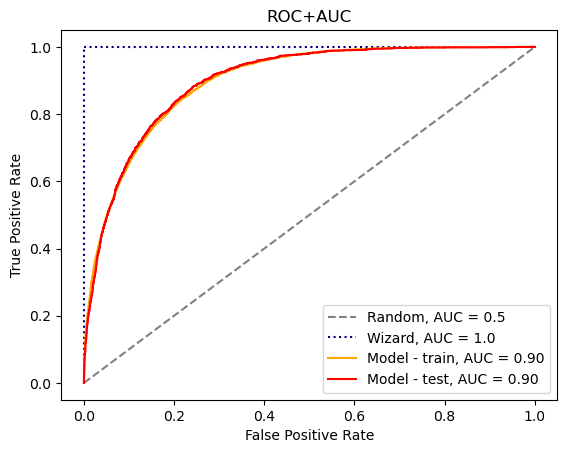

In [77]:
y_prob_train = best_model_lr.predict_proba(X_train)[:,1]
y_prob_test = best_model_lr.predict_proba(X_test)[:, 1]

fprv, tprv, _ = roc_curve(y_test, y_prob_test)
fprt, tprt, _ = roc_curve(y_train, y_prob_train)

auc_test = roc_auc_score(y_test, y_prob_test)
auc_train = roc_auc_score(y_train, y_prob_train)
print("AUC_test:", auc_test, "AUC_train:", auc_train)

plt.figure()

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC+AUC")

plt.plot([0, 1], [0, 1], color="grey", linestyle="--", label="Random, AUC = 0.5")
plt.plot([0, 0], [0, 1], color="navy", linestyle=":", label="Wizard, AUC = 1.0")
plt.plot([0, 1], [1, 1], color="navy", linestyle=":")

plt.plot(fprt, tprt, color="orange", label="Model - train, AUC = %0.2f" % auc_train)
plt.plot(fprv, tprv, color="red", label="Model - test, AUC = %0.2f" % auc_test)
plt.legend(loc="lower right");

In [79]:
#tworzenie tabeli z ilorazami szans

feature_names = best_model_lr.named_steps["preprocess"].get_feature_names_out()
odds_ratio = np.exp(best_model_lr.named_steps["model"].coef_)

df_or = pd.DataFrame({
    "feature": feature_names,
    "odds_ratio": odds_ratio[0]}).sort_values("odds_ratio", ascending=False)
df_or

,feature,odds_ratio
41,cat__relationship_Wife,5.520310
1,num__education-num,2.073054
19,cat__occupation_Exec-managerial,2.068130
13,cat__marital-status_Married,1.956758
24,cat__occupation_Prof-specialty,1.747885
25,cat__occupation_Protective-serv,1.722900
2,num__capital_gain,1.716347
27,cat__occupation_Tech-support,1.664640
5,cat__workclass_Federal-gov,1.633489
36,cat__relationship_Husband,1.593189


Najsilniejszy pozytywny wpływ na prawdopodobieństwo osiągnięcia dochodu powyżej 50K ma zmienna "relationship = Wife" (OR ≈ 5.5), co oznacza ponad pięciokrotnie większe szanse wysokiego dochodu w porównaniu do pozostałych kategorii tej zmiennej. Istotne znaczenie ma również poziom wykształcenia – wzrost "education-num" o jedną jednostkę ponad dwukrotnie zwiększa szanse wysokich zarobków (OR ≈ 2.07). Im wyższy jest poziom wykształcenia, tym większe jest prawdopodobieństwo wyższego dochodu.

Z kolei zmienne o ilorazach szans mniejszych od 1 obniżają prawdopodobieństwo wysokiego dochodu. Najsilniejszy negatywny wpływ obserwowany jest dla kategorii "relationship = Own-child" (OR ≈ 0.30). Niższe szanse wysokich zarobków dotyczą także m.in. osób pracujących w zawodach Farming-fishing i Other-service, osób nigdy niebędących w związku małżeńskim oraz kobiet.